In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from fuzzywuzzy import process
from IPython.display import display

print("Libraries imported successfully!")
    

Libraries imported successfully!


In [2]:

file_path = 'Sales_Data_.xlsx'

sales_df = pd.read_excel(file_path, sheet_name='Sales', skiprows=3)
sales_df.columns = sales_df.columns.map(str)
sales_df = sales_df.loc[:, ~sales_df.columns.str.contains('^Unnamed') | (sales_df.columns == 'Inconsistent_Flag')]
sales_df = sales_df.rename(columns={'True': 'Inconsistent_Flag'})

print(sales_df.columns.tolist())
    

['City', 'Region Code', 'No.of Cars', 'Price per car', 'Total Amount', 'Order Date', 'Month', 'Year', 'Product', 'Sales Person', 'Inconsistent_Flag']


In [3]:

def fix_date_column(df, date_column='Order Date'):
    try:
        df[date_column] = pd.to_datetime(df[date_column], dayfirst=True, errors='coerce')
        print(f"Date column '{date_column}' converted successfully!")
        return df
    except Exception as e:
        print(f"Error converting date column: {e}")
        return df

sales_df = fix_date_column(sales_df)
    

Date column 'Order Date' converted successfully!


In [4]:

def split_product_column(df):
    try:
        split_cols = df['Product'].str.split('|', expand=True)
        df['Car Model'] = split_cols[0]
        df['Car Make'] = split_cols[1]
        print("Product column split successfully!")
        return df
    except Exception as e:
        print(f"Error splitting Product column: {e}")
        return df

sales_df = split_product_column(sales_df)
    

Product column split successfully!


In [5]:

sales_df = sales_df.dropna(subset=['Product']).reset_index(drop=True)
    

In [6]:

def clean_city_column(df):
    try:
        df['City'] = df['City'].astype(str).str.strip().str.title().str.replace('[^A-Za-z ]', '', regex=True)
        print("City column cleaned successfully!")
        return df
    except Exception as e:
        print(f"Error cleaning City column: {e}")
        return df

sales_df = clean_city_column(sales_df)
    

City column cleaned successfully!


In [7]:

region_master_df = pd.read_excel(file_path, sheet_name='Region Master')
    

In [9]:

product_master_df = pd.read_excel(file_path, sheet_name='Product Master', skiprows=1)
product_master_df.columns = product_master_df.columns.map(str)
product_master_df = product_master_df.drop(columns=[col for col in product_master_df.columns if 'Unnamed' in col])
    

In [10]:

def merge_region_master(sales_df, region_master_df):
    try:
        merged_df = pd.merge(
            sales_df,
            region_master_df[['Region Code', 'Region Name', 'Country']],
            how='left',
            on='Region Code'
        )
        print("Region Master merged successfully!")
        return merged_df
    except Exception as e:
        print(f"Error merging Region Master: {e}")
        return sales_df

sales_df = merge_region_master(sales_df, region_master_df)
    

Region Master merged successfully!


In [11]:

def merge_product_master(sales_df, product_master_df):
    try:
        merged_df = pd.merge(
            sales_df,
            product_master_df[['Car Model', 'Car Make', 'Category']],
            how='left',
            on=['Car Model', 'Car Make']
        )
        print("Product Master merged successfully!")
        return merged_df
    except Exception as e:
        print(f"Error merging Product Master: {e}")
        return sales_df

sales_df = merge_product_master(sales_df, product_master_df)
    

Product Master merged successfully!


In [16]:

def recalculate_flag(df):
    try:
        df['Inconsistent_Flag'] = np.where(
            (df['Product'].isnull()) |
            (df['Total Amount'].isnull()) |
            (df['Order Date'].isnull()) |
            (df['Total Amount'] == 0),
            1, 0
        )
        print("Inconsistent_Flag recalculated successfully!")
        return df
    except Exception as e:
        print(f"Error recalculating flag: {e}")
        return df

sales_df = recalculate_flag(sales_df)
    

Inconsistent_Flag recalculated successfully!


In [17]:

duplicate_keys = ['City', 'Region Code', 'Car Make', 'Car Model']
sales_df = sales_df.sort_values(by='Order Date', ascending=False)
sales_df = sales_df.drop_duplicates(subset=duplicate_keys, keep='first').reset_index(drop=True)
print(f"Shape after removing duplicates: {sales_df.shape}")
    

Shape after removing duplicates: (12024, 16)


In [18]:

output_file_path = 'Cleaned_Sales_Data.xlsx'
sales_df.to_excel(output_file_path, index=False)
print(f"Cleaned sales data saved successfully as '{output_file_path}'!")
    

Cleaned sales data saved successfully as 'Cleaned_Sales_Data.xlsx'!


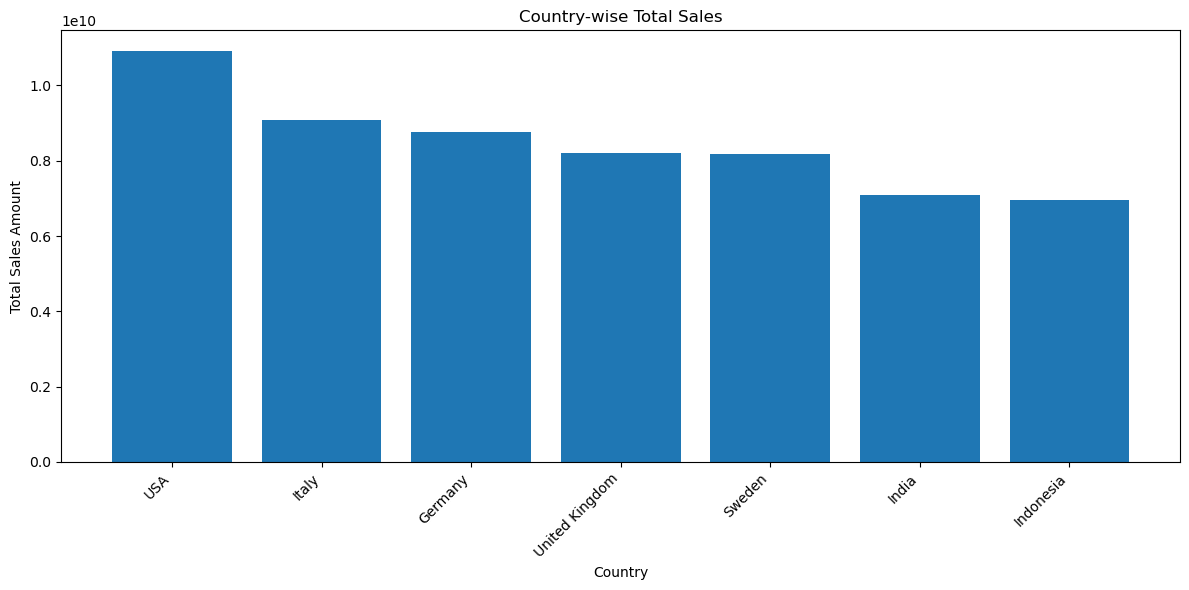

In [20]:

country_sales = sales_df.groupby('Country')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)
folder_path = 'Sales_trend_visualizations'
os.makedirs(folder_path, exist_ok=True)
plt.figure(figsize=(12, 6))
plt.bar(country_sales['Country'], country_sales['Total Amount'])
plt.xlabel('Country')
plt.ylabel('Total Sales Amount')
plt.title('Country-wise Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
chart_path = os.path.join(folder_path, 'country_wise_sales.png')
plt.savefig(chart_path)
plt.show()
    

C:\Vijay\AppData\Local\Temp\ipykernel_25164\2917292986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sales_df['Quarter'] = top_sales_df['Order Date'].dt.to_period('Q')


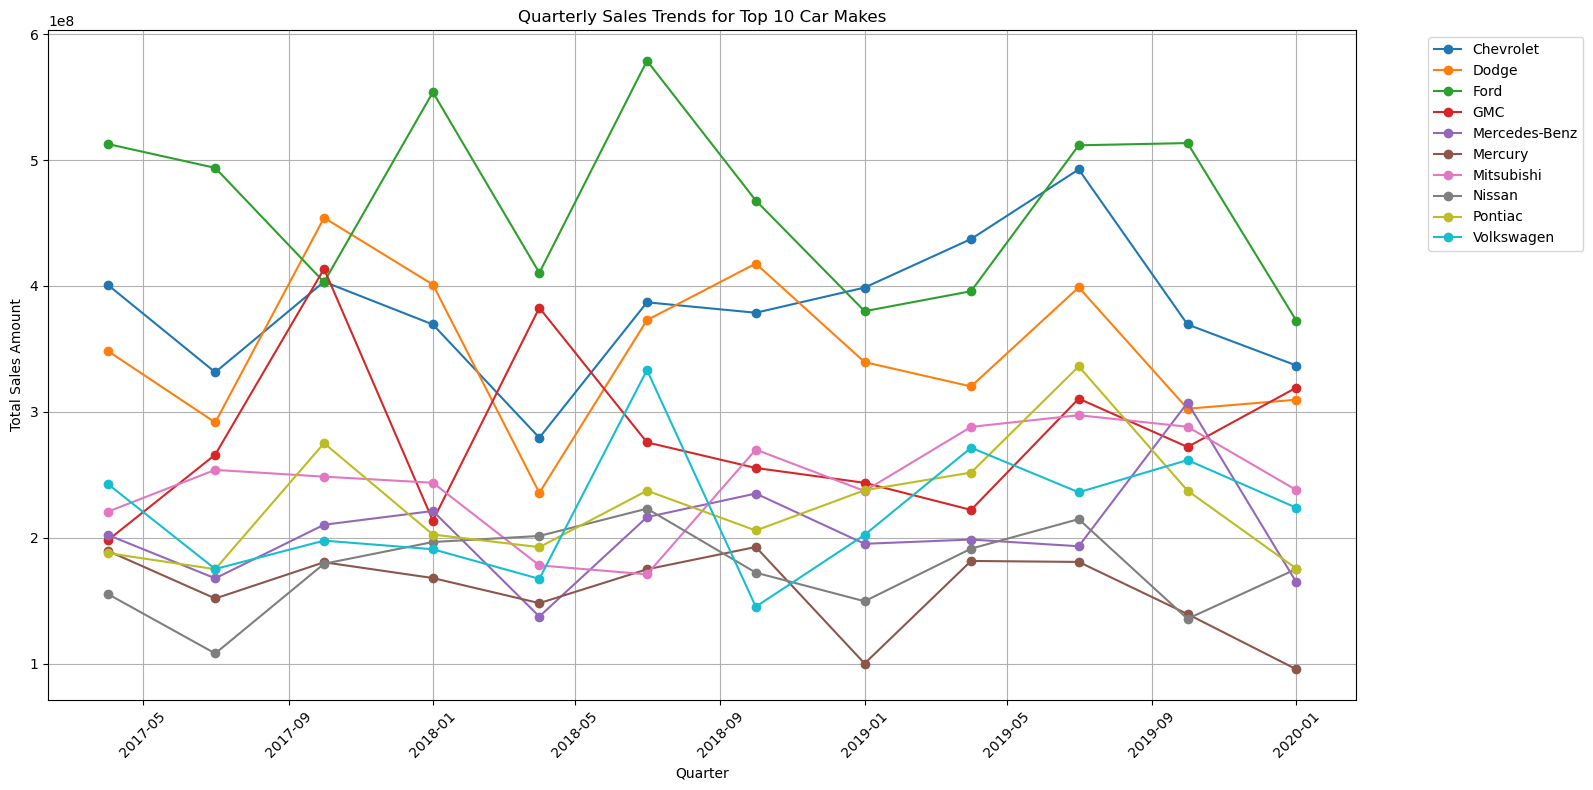

In [21]:

top_10_car_makes = sales_df.groupby('Car Make')['Total Amount'].sum().sort_values(ascending=False).head(10).index.tolist()
top_sales_df = sales_df[sales_df['Car Make'].isin(top_10_car_makes)]
top_sales_df['Quarter'] = top_sales_df['Order Date'].dt.to_period('Q')
quarterly_sales_top = top_sales_df.groupby(['Quarter', 'Car Make'])['Total Amount'].sum().reset_index()
pivot_table_top = quarterly_sales_top.pivot(index='Quarter', columns='Car Make', values='Total Amount').fillna(0)
plt.figure(figsize=(16, 8))
for car_make in pivot_table_top.columns:
    plt.plot(pivot_table_top.index.to_timestamp(), pivot_table_top[car_make], label=car_make, marker='o')
plt.xlabel('Quarter')
plt.ylabel('Total Sales Amount')
plt.title('Quarterly Sales Trends for Top 10 Car Makes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
chart_path = os.path.join(folder_path, 'quarterly_sales_trends_top10.png')
plt.savefig(chart_path, dpi=300)
plt.show()
    

In [ ]:

product_sales = sales_df.groupby('Car Model')['Total Amount'].sum().reset_index()
total_sales = product_sales['Total Amount'].sum()
product_sales['% Contribution'] = (product_sales['Total Amount'] / total_sales) * 100
product_sales = product_sales.sort_values(by='% Contribution', ascending=False)
top_10_products = product_sales.head(10)
display(top_10_products[['Car Model', 'Total Amount', '% Contribution']])
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    top_10_products['% Contribution'],
    labels=top_10_products['Car Model'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Top 10 Car Models - Contribution to Total Sales (Donut Chart)')
plt.axis('equal')
plt.tight_layout()
chart_path = os.path.join(folder_path, 'top10_product_contribution_donut.png')
plt.savefig(chart_path, dpi=300)
plt.show()
    

In [22]:

region_car_make_sales = sales_df.groupby(['Region Name', 'Car Make'])['Total Amount'].sum().reset_index()
top_car_make_per_region = region_car_make_sales.sort_values(['Region Name', 'Total Amount'], ascending=[True, False]).drop_duplicates('Region Name')
display(top_car_make_per_region[['Region Name', 'Car Make', 'Total Amount']])
    

,Region Name,Car Make,Total Amount
14,Aberdeenshire,Nissan,14602650.0
24,Aceh,Ford,27940780.0
39,Alaska,BMW,32385569.0
68,Andhra Pradesh,Chevrolet,51253515.0
101,Anglesey,Ford,31482606.0
...,...,...,...
3941,Wigtownshire,Chevrolet,28962924.0
3969,Wiltshire,Volkswagen,19982844.0
3978,Wyoming,Ford,69235941.0
4009,Yorkshire,Ford,53211838.0
